# Edge Site Deployment Problem

README : https://drive.google.com/file/d/1VnIAq9jaCVT_F9twUAfXWSl8Qf19Xq0h/view?usp=sharing

Overleaf : https://www.overleaf.com/project/65ba3bfef3a9ee6d066f2f71

## Imports

In [1]:
from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import pyproj
import time
from multiprocessing import Pool
from scipy.spatial import KDTree

import folium
from folium.plugins import HeatMap

## Constants

In [2]:
# Define the coverage distance (in meter) edge placement (if a user is farther than S meters from the placement, then they're not covered)
S = 1000

## Data

In [3]:
# Drive connection
drive.mount('/content/drive', force_remount=True)

# Path when the files are in a shared drive
path = '"/content/drive/Shareddrives/ING3 Metaheuristic Optimization/"'

# Move in directories
%cd $path

Mounted at /content/drive
/content/drive/Shareddrives/ING3 Metaheuristic Optimization


In [4]:
df_users = pd.read_csv('./eua-dataset-master/users/users-melbmetro-generated.csv')
df_servers = pd.read_csv('./eua-dataset-master/edge-servers/site.csv')

df_users.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
print("users_coord head: \n", df_users.head())
print("users_coord type:", type(df_users))
print("users_coord length:", len(df_users))

df_servers.drop(columns={'SITE_ID', 'NAME', 'STATE', 'LICENSING_AREA_ID', 'POSTCODE', 'SITE_PRECISION', 'ELEVATION', 'HCIS_L2'}, inplace=True)
df_servers.rename(columns={'LATITUDE': 'lat', 'LONGITUDE': 'lon'}, inplace=True)
df_servers.head()
print("\nservers_coord head: \n", df_servers.head())
print("servers_coord type:", type(df_servers))
print("servers_coord length:", len(df_servers))

users_coord head: 
          lat         lon
0 -37.825944  145.335710
1 -37.842604  145.360843
2 -37.899837  145.356431
3 -37.887066  145.367571
4 -37.852409  145.330123
users_coord type: <class 'pandas.core.frame.DataFrame'>
users_coord length: 131312

servers_coord head: 
          lat         lon
0 -12.471947  130.845073
1 -33.756158  150.698182
2 -28.777660  114.634260
3 -12.464597  130.840708
4 -39.596400  143.933900
servers_coord type: <class 'pandas.core.frame.DataFrame'>
servers_coord length: 95562


In [5]:
# Define a projection
proj = pyproj.Proj(proj='utm', zone=55, ellps='WGS84')

# Convert DataFrame columns from lat/lon to x/y
df_users['x'], df_users['y'] = proj(df_users['lon'].values, df_users['lat'].values)
df_servers['x'], df_servers['y'] = proj(df_servers['lon'].values, df_servers['lat'].values)

print("users_coord head: \n", df_users.head())
print("users_coord type:", type(df_users))
print("users_coord length:", len(df_users))

print("\nservers_coord head: \n", df_servers.head())
print("servers_coord type:", type(df_servers))
print("servers_coord length:", len(df_servers))

users_coord head: 
          lat         lon              x             y
0 -37.825944  145.335710  353529.969863 -4.187808e+06
1 -37.842604  145.360843  355774.451471 -4.189618e+06
2 -37.899837  145.356431  355498.080585 -4.195975e+06
3 -37.887066  145.367571  356452.793142 -4.194541e+06
4 -37.852409  145.330123  353090.772005 -4.190754e+06
users_coord type: <class 'pandas.core.frame.DataFrame'>
users_coord length: 131312

servers_coord head: 
          lat         lon             x             y
0 -12.471947  130.845073 -1.277083e+06 -1.433933e+06
1 -33.756158  150.698182  8.425835e+05 -3.741268e+06
2 -28.777660  114.634260 -2.748638e+06 -3.657890e+06
3 -12.464597  130.840708 -1.277628e+06 -1.433120e+06
4 -39.596400  143.933900  2.367205e+05 -4.387455e+06
servers_coord type: <class 'pandas.core.frame.DataFrame'>
servers_coord length: 95562


In [6]:
# Create a KD-tree from the user coordinates
user_tree = KDTree(df_users[['x', 'y']].values)

# Find the distance and index of the nearest user for each server
distances, indices = user_tree.query(df_servers[['x', 'y']].values)

# Filter the servers DataFrame to only include servers within a certain distance of a user
df_servers = df_servers[distances <= S]

print("\nservers_coord head: \n", df_servers.head())
print("servers_coord type:", type(df_servers))
print("servers_coord length:", len(df_servers))


servers_coord head: 
           lat         lon              x             y
21 -37.814712  144.974322  321695.027955 -4.187190e+06
22 -37.651230  144.959774  320018.854103 -4.169077e+06
26 -37.810900  144.937100  318408.966586 -4.186839e+06
27 -37.916514  145.038261  327561.153441 -4.198367e+06
29 -37.919200  145.346300  354645.412784 -4.198139e+06
servers_coord type: <class 'pandas.core.frame.DataFrame'>
servers_coord length: 9229


In [7]:
def create_heatmap(df, zoom_start=9, radius=10):
    # Create a map centered at an average location
    map = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=zoom_start)

    # Create a heatmap for df
    HeatMap(data=df[['lat', 'lon']].values, radius=radius).add_to(map)

    # Return the map
    return map

create_heatmap(df_servers)

In [8]:
create_heatmap(df_users)

Output hidden; open in https://colab.research.google.com to view.

In [9]:
# Define the number of candidate placements and users
P = len(df_servers)
U = len(df_users)

# Define the cost and coverage for each placement
m = [random.randint(1, 3) for _ in range(P)]

# Define trees with coordinates of users and candidate placements
lU_tree = KDTree(df_users[['x', 'y']].values)
lP_tree = KDTree(df_servers[['x', 'y']].values)

print("lU_tree type:", type(lU_tree))
print("lP_tree type:", type(lP_tree))

lU_tree type: <class 'scipy.spatial._kdtree.KDTree'>
lP_tree type: <class 'scipy.spatial._kdtree.KDTree'>


## Modelization

In [10]:
# Define the coverage function
def coverage_pu(lP_subtree, u_coords):
    """
    Defines if a user is covered by an antenna

    #### Parameters:
    :lP_subtree: KDTree of the antennas that are turned on
    :u_coords: coordinates of the users

    #### Return:
    List of booleans, `True` if the user is covered by an antenna
    """
    distances, _ = lP_subtree.query(u_coords)
    return distances <= S

# Define the fitness functions
def objQ_coverage(x):
    """
    Compute Q value, the overall user coverage of the given solution

    #### Parameter:
    :x: list of booleans, `True` if the antenna is turned on

    #### Return:
    Float value between 0 and 100
    """
    # Get the indices of the antennas that are turned on
    on_antennas = [i for i, val in enumerate(x) if val == 1]

    # Create a subtree using only the antennas that are turned on
    lP_subtree = KDTree(lP_tree.data[on_antennas])

    # Get the coordinates of all users
    u_coords = lU_tree.data

    # Compute coverage for all users at once
    C = coverage_pu(lP_subtree, u_coords)

    Q = sum(C) / len(u_coords) * 100
    return Q

def objM_cost(x):
  """
  Compute M value, the total monetary cost of the given solution

  #### Parameter:
  :x: list of booleans, true if the antenna is turned on

  #### Return:
  Float value
  """
  return sum([x[i]*m[i] for i in range(len(x))])


def pareto_dominance(solution1, solution2, obj_func_m, obj_func_q):
    m1 = obj_func_m(solution1)
    m2 = obj_func_m(solution2)
    q1 = obj_func_q(solution1)
    q2 = obj_func_q(solution2)

    if (m1 <= m2 and q1 >= q2) or (m1 < m2 and q1 > q2):
      return 1
    elif (m1 >= m2 and q1 <= q2) or (m1 > m2 and q1 < q2):
      return -1
    else:
      return 0

## Resolution

### Auxiliary functions

In [11]:
def plot_solutions(solutions, obj1_name="Objective f1", obj2_name="Objective f2"):
  """
  Plot solution points

  #### Parameters:
  :solutions: list of tupples `(solution, f1(solution), f2(solution))`
  :obj1_name: string, name of the first objective
  :obj2_name: string, name of the second objective

  #### Return:
  None
  """

  print(f"Theoretical maximum coverage for S = {S}m is {round(objQ_coverage(True for _ in range(P)), 2)} %")

  f1_values = []
  f2_values = []
  for x, f1_x, f2_x in solutions:
      f1_values.append(f1_x)
      f2_values.append(f2_x)

  plt.scatter(f1_values, f2_values)
  plt.xlabel(obj1_name)
  plt.ylabel(obj2_name)
  plt.title('Pareto Front')
  plt.show()


def plot_solutions_comparison(list_solutions, solu_names=[], obj1_name="Objective f1", obj2_name="Objective f2"):
  """
  Plot solution points

  #### Parameters:
  :solutions: list of list of tupples `(solution, f1(solution), f2(solution))`
  :solu_names: list of strings of the solutions' names
  :obj1_name: string, name of the first objective
  :obj2_name: string, name of the second objective

  #### Return:
  None
  """

  print(f"Theoretical maximum coverage for S = {S}m is {round(objQ_coverage(True for _ in range(P)), 2)} %")

  if not(solu_names):
    solu_names = ["solution"+str(i) for i in range(len(list_solutions))]

  colors = ["red", "blue", "green", "yellow"]
  for i,solutions in enumerate(list_solutions):
    f1_values = []
    f2_values = []
    for x, f1_x, f2_x in solutions:
        f1_values.append(f1_x)
        f2_values.append(f2_x)

    plt.scatter(f1_values, f2_values, c=colors[i], label=solu_names[i])

  plt.xlabel(obj1_name)
  plt.ylabel(obj2_name)
  plt.title('Pareto Front')
  plt.legend()
  plt.show()

### Simulated Annealing

In [12]:
def simulated_annealing_2obj(f1, f2, solution_len, T=1000, alpha=0.9, iterations=1000, flip_bits=10, initializor=1, verbose=False):
    """
    Perform Simulated Annealing for multi-objective optimization.

    #### Parameters:
    :f1: function, first objective function
    :f2: funcbjective ftion, second ounction
    :solution_len: int, length of the solution
    :T: float, initial temperature
    :alpha: float, cooling rate
    :iterations: int, number of iterations
    :flip_bits: int, number of bits to flip to generate neighbor solution
    :initializor: function that generates an integer to initialize the initial solution
    :verbose: bool, whether to print execution time

    #### Return:
    :pareto: list of tuples, each tuple contains a solution and its objective function values
    """

    # Record the start time
    start_time = time.time()

    # Initialize initial solution
    x = [initializor for _ in range(solution_len)]

    # Initialize the Pareto list
    pareto = [(x, f1(x), f2(x))]

    # Perform the simulated annealing
    for iteration in range(iterations):
        # Generate a neighbor solution
        x_prime = x[:]
        for _ in range(flip_bits):
            i = random.randint(0, solution_len - 1)
            x_prime[i] = 1 - x_prime[i]

        # Calculate the fitness of the neighbor solution
        f1_x_prime = f1(x_prime)
        f2_x_prime = f2(x_prime)

        # Update the Pareto list
        pareto = [p for p in pareto if p[1] > f1_x_prime or p[2] < f2_x_prime]
        if not any(p[1] >= f1_x_prime and p[2] <= f2_x_prime for p in pareto):
            pareto.append((x_prime, f1_x_prime, f2_x_prime))

        # Accept the neighbor solution if it is not worse
        if f1_x_prime >= f1(x) and f2_x_prime <= f2(x):
            x = x_prime
        # Else, accept the neighbor solution with a certain probability
        elif random.random() < np.exp((f1(x) + f2(x)) / T) / np.exp((f1_x_prime + f2_x_prime) / T):
            x = x_prime

        # Decrease the temperature
        T = alpha * T

    # Calculate the total elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time

    if verbose:
        print(f"Total execution time: {elapsed_time:.2f} seconds")

    return pareto

<ipython-input-12-0809ae2fd018>:50: RuntimeWarning: overflow encountered in exp
  elif random.random() < np.exp((f1(x) + f2(x)) / T) / np.exp((f1_x_prime + f2_x_prime) / T):
<ipython-input-12-0809ae2fd018>:50: RuntimeWarning: invalid value encountered in scalar divide
  elif random.random() < np.exp((f1(x) + f2(x)) / T) / np.exp((f1_x_prime + f2_x_prime) / T):


Total execution time: 39.96 seconds
Theoretical maximum coverage for S = 1000m is 88.84 %


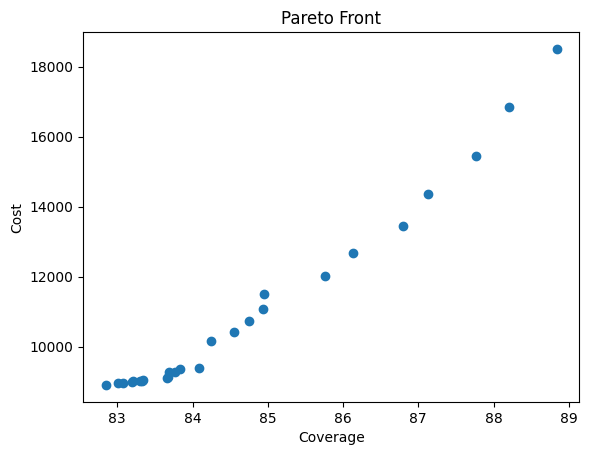

In [13]:
pareto = simulated_annealing_2obj(objQ_coverage, objM_cost, P, iterations=100, flip_bits=int(P * 0.1), alpha=0.95, verbose=True)
plot_solutions(pareto, "Coverage", "Cost")

### Multi-Objective Firefly Algorithm (MOFA)

In [14]:
# FA algorithm implementation
def generate_initial_population(population_size):
    """
    Generate initial population with random solutions.
    """
    population = []
    for _ in range(population_size):
        solution = [random.randint(0, 1) for _ in range(P)]
        population.append(solution)
    return population


def update_position(current_position, global_best, attraction, randomness, mutation):
    """
    Update the position of a firefly based on the global best position.

    :current_position: position of the firefly
    :global_best: position of the best firefly
    :attraction: attraction coefficient
    :randomness: randomness coefficient
    :mutation: mutation coefficient
    """
    a = attraction
    b = randomness
    c = mutation

    r = random.random()  # Random number between 0 and 1

    new_position = []
    for i in range(len(current_position)):
        direction = a * (current_position[i] - global_best[i]) + b * (random.random() - 0.5)
        mutation = c * (random.random() - 0.5)
        new_value = current_position[i] + direction + mutation * r
        new_position.append(min(max(new_value, 0), 1))  # Ensure the position is within bounds [0, 1]

    return new_position


def multi_objective_fa_algorithm(f1, f2, population_size, max_generations, attraction=2, randomness=1, mutation=1, verbose=0):
    """
    Perform multi-objective FA algorithm.

    :f1: first objective function to maximize
    :f2: second objective function to minimize
    :population_size: number of fireflies to generate in swarm
    :max_generations: number of swarm generations
    :attraction: attraction coefficient
    :randomness: randomness coefficient
    :mutation: mutation coefficient
    :verbose: int, display option
    """

    # Record the start time
    start_time = time.time()

    if verbose > 1:
      print("Initialisation")
    population = generate_initial_population(population_size)
    x = population[0]
    pareto = [(x, f1(x),f2(x))]


    for h in range(max_generations):
        if verbose > 1:
            print("Generation #",h)
        for i in range(len(population)):
            if verbose > 1:
                print("- Loop #",i)
            for j in range(len(population)):
                if (i != j):
                    if pareto_dominance(population[j], population[i], f1, f2) > 0:
                        population[i] = update_position(population[i], population[j], attraction, randomness, mutation)
                    if verbose > 1:
                        print("-- Loop #",j)
                elif verbose > 1:
                    print("-- Skip loop #",j)

            if verbose > 1:
                print("- Computing Pareto")
            x_prime = [int(p) for p in population[i]]
            f1_x_prime = f1(x_prime)
            f2_x_prime = f2(x_prime)
            pareto = [(x, f1_x, f2_x) for x, f1_x, f2_x in pareto if f1_x > f1_x_prime or f2_x < f2_x_prime]
            if not any(f1_x >= f1_x_prime and f2_x <= f2_x_prime for _, f1_x, f2_x in pareto):
                pareto.append((x_prime, f1_x_prime, f2_x_prime))

    # Calculate the total elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    if verbose > 0:
        print(f"Total execution time: {elapsed_time:.2f} seconds")

    return pareto



Total execution time: 117.55 seconds
Theoretical maximum coverage for S = 1000m is 88.84 %


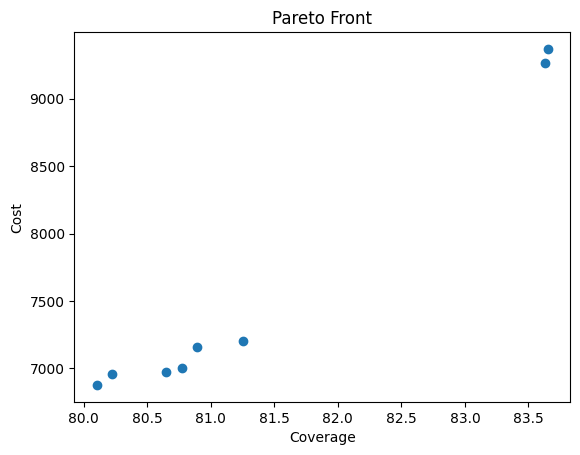

In [15]:
best_solutions = multi_objective_fa_algorithm(objQ_coverage, objM_cost, population_size=20, max_generations=1, verbose=1)
plot_solutions(best_solutions, "Coverage", "Cost")

## Algorithms comparison

Theoretical maximum coverage for S = 1000m is 88.84 %


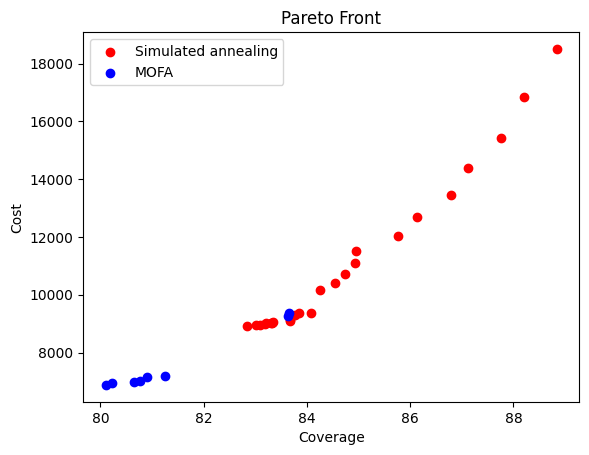

In [16]:
plot_solutions_comparison([pareto, best_solutions], ["Simulated annealing", "MOFA"], "Coverage", "Cost")

### Dominance matrix

In [17]:
def dominance_matrix (solutions1, solutions2):
  mat = []
  for s1,q1,m1 in solutions1:
    mat.append([])
    for s2,q2,m2 in solutions2:
      if (m1 <= m2 and q1 >= q2) or (m1 < m2 and q1 > q2):
        mat[-1].append(1)
      elif (m1 >= m2 and q1 <= q2) or (m1 > m2 and q1 < q2):
        mat[-1].append(-1)
      else:
        mat[-1].append(0)
  return mat

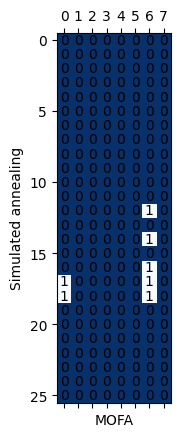

In [18]:
dom_mat = dominance_matrix(pareto, best_solutions)
plt.matshow(dom_mat, 0, cmap="Blues_r")
plt.xlabel("MOFA")
plt.ylabel("Simulated annealing")
for i in range(len(dom_mat)):
   for j in range(len(dom_mat[i])):
      c = dom_mat[i][j]
      plt.text(j, i, str(c), va='center', ha='center')
plt.show()

### Efficiency

In [19]:
def pareto_efficiency(dom_mat, sol_names=("sol1","sol2")):
  for i in range(len(sol_names)):
    pareto_eff = len(np.where(np.sum(dom_mat, i) == 0)[0])
    print("Pareto efficiency of "+str(sol_names[i])+" on "+str(sol_names[(i+1)%2])+" is equal to "+str(pareto_eff)+" .")

In [20]:
pareto_efficiency(dom_mat, ("MOFA", "Simulated annealing"))

Pareto efficiency of MOFA on Simulated annealing is equal to 6 .
Pareto efficiency of Simulated annealing on MOFA is equal to 21 .


### Contribution

In [21]:
def pareto_contribution(dom_mat, solutions):
  c = sum([1 if s1 in solutions[1] else 0 for s1 in solutions[0]])
  w1 = len(np.where(np.sum(dom_mat, 0) > 0)[0])
  w2 = len(np.where(np.sum(dom_mat, 1) > 0)[0])
  n1 = len(np.where(np.sum(dom_mat, 0) == 0)[0])
  n2 = len(np.where(np.sum(dom_mat, 1) == 0)[0])
  cont = ((c/2) + w1 + n1) / (c + w1 + w2 + n1 + n2)
  return cont

In [22]:
print(
    "CONT(MOFA, Simulated_annealing) = ", pareto_contribution(dom_mat, (pareto, best_solutions))
)
print(
    "CONT(Simulated_annealing, MOFA) = ", pareto_contribution(np.transpose(dom_mat), (best_solutions, pareto))
)

CONT(MOFA, Simulated_annealing) =  0.23529411764705882
CONT(Simulated_annealing, MOFA) =  0.7647058823529411


## Algorithms optimization

<ipython-input-12-0809ae2fd018>:50: RuntimeWarning: overflow encountered in exp
  elif random.random() < np.exp((f1(x) + f2(x)) / T) / np.exp((f1_x_prime + f2_x_prime) / T):
<ipython-input-12-0809ae2fd018>:50: RuntimeWarning: invalid value encountered in scalar divide
  elif random.random() < np.exp((f1(x) + f2(x)) / T) / np.exp((f1_x_prime + f2_x_prime) / T):


Theoretical maximum coverage for S = 1000m is 88.84 %


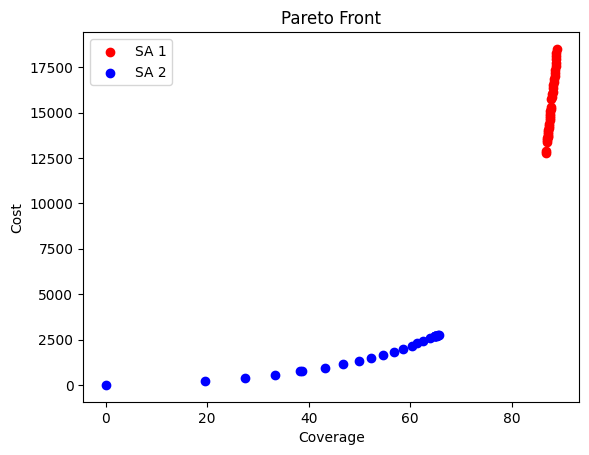

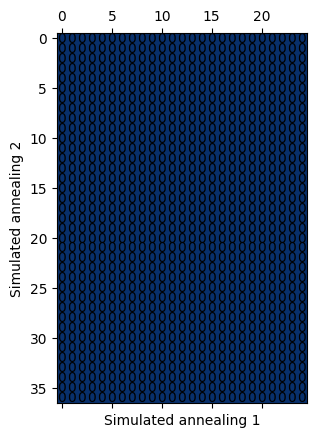

Pareto efficiency of Simulated annealing 1 on Simulated annealing 2 is equal to 25 .
Pareto efficiency of Simulated annealing 2 on Simulated annealing 1 is equal to 37 .
CONT(SA1, SA2) =  0.4032258064516129
CONT(SA2, SA1) =  0.5967741935483871


In [23]:
#@title Simulated annealing

#@markdown - Parameters for optimizer n°1:

random_initialization_1 = False # @param {type:"boolean"}
temperature_1 = 1000 # @param {type:"slider", min:0, max:1000, step:100}
alpha_1 = 0.9 # @param {type:"number"}
iterations_1 = 100 #@param {type:"slider", min:0, max:100, step:10}
flip_bits_1 = 100 # @param {type:"integer"}

#@markdown - Parameters for optimizer n°2:

random_initialization_2 = True # @param {type:"boolean"}
temperature_2 = 1000 # @param {type:"slider", min:0, max:1000, step:100}
alpha_2 = 0.9 # @param {type:"number"}
iterations_2 = 100 #@param {type:"slider", min:0, max:100, step:10}
flip_bits_2 = 100 # @param {type:"integer"}


if random_initialization_1:
  initializor_1 = random.randint(0,1)
else:
  initializor_1 = 1

sa_sol1 = simulated_annealing_2obj(
    objQ_coverage,
    objM_cost,
    P,
    iterations=iterations_1,
    flip_bits=flip_bits_1,
    alpha=alpha_1,
    initializor=initializor_1
)


if random_initialization_2:
  initializor_2 = random.randint(0,1)
else:
  initializor_2 = 1

sa_sol2 = simulated_annealing_2obj(
    objQ_coverage,
    objM_cost,
    P,
    iterations=iterations_2,
    flip_bits=flip_bits_2,
    alpha=alpha_2,
    initializor=initializor_2
)

plot_solutions_comparison([sa_sol1, sa_sol2], ["SA 1", "SA 2"], "Coverage", "Cost")

dom_mat_sa = dominance_matrix(sa_sol1, sa_sol2)
plt.matshow(dom_mat_sa, 0, cmap="Blues_r")
plt.xlabel("Simulated annealing 1")
plt.ylabel("Simulated annealing 2")
for i in range(len(dom_mat_sa)):
   for j in range(len(dom_mat_sa[i])):
      c = dom_mat_sa[i][j]
      plt.text(j, i, str(c), va='center', ha='center')
plt.show()

pareto_efficiency(dom_mat_sa, ("Simulated annealing 1", "Simulated annealing 2"))

print(
    "CONT(SA1, SA2) = ", pareto_contribution(dom_mat_sa, (sa_sol1, sa_sol2))
)
print(
    "CONT(SA2, SA1) = ", pareto_contribution(np.transpose(dom_mat_sa), (sa_sol2, sa_sol1))
)

Theoretical maximum coverage for S = 1000m is 88.84 %


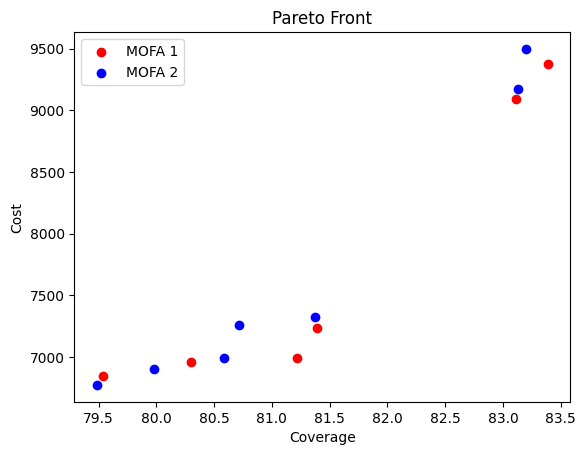

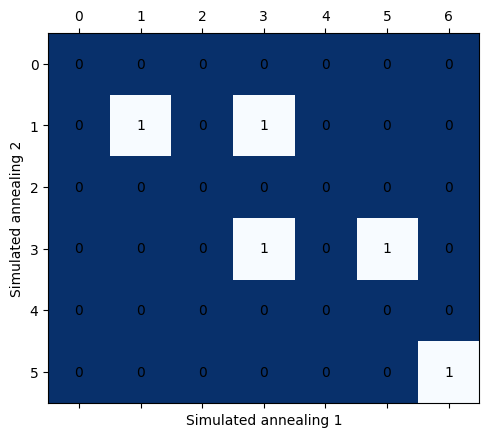

Pareto efficiency of Simulated annealing 1 on Simulated annealing 2 is equal to 3 .
Pareto efficiency of Simulated annealing 2 on Simulated annealing 1 is equal to 3 .
CONT(FA1, FA2) =  0.5384615384615384
CONT(FA2, FA1) =  0.46153846153846156


In [24]:
#@title MOFA

#@markdown - Parameters for optimizer n°1:

generations_1 = 1 #@param {type:"slider", min:0, max:5, step:1}
nb_fireflies_1 = 10 #@param {type:"slider", min:0, max:50, step:1}
attraction_1 = 2 # @param {type:"number"}
randomness_1 = 1 # @param {type:"number"}
mutation_1 = 1 # @param {type:"number"}


#@markdown - Parameters for optimizer n°2:

generations_2 = 2 #@param {type:"slider", min:0, max:5, step:1}
nb_fireflies_2 = 10 #@param {type:"slider", min:0, max:50, step:1}
attraction_2 = 2 # @param {type:"number"}
randomness_2 = 1 # @param {type:"number"}
mutation_2 = 1 # @param {type:"number"}



mofa_sol1 = multi_objective_fa_algorithm(
    objQ_coverage,
    objM_cost,
    nb_fireflies_1,
    generations_1,
    attraction_1,
    randomness_1,
    mutation_1
)

mofa_sol2 = multi_objective_fa_algorithm(
    objQ_coverage,
    objM_cost,
    nb_fireflies_2,
    generations_2,
    attraction_2,
    randomness_2,
    mutation_2
)

plot_solutions_comparison([mofa_sol1, mofa_sol2], ["MOFA 1", "MOFA 2"], "Coverage", "Cost")

dom_mat_mofa = dominance_matrix(mofa_sol1, mofa_sol2)
plt.matshow(dom_mat_mofa, 0, cmap="Blues_r")
plt.xlabel("Simulated annealing 1")
plt.ylabel("Simulated annealing 2")
for i in range(len(dom_mat_mofa)):
   for j in range(len(dom_mat_mofa[i])):
      c = dom_mat_mofa[i][j]
      plt.text(j, i, str(c), va='center', ha='center')
plt.show()

pareto_efficiency(dom_mat_mofa, ("Simulated annealing 1", "Simulated annealing 2"))

print(
    "CONT(FA1, FA2) = ", pareto_contribution(dom_mat_mofa, (mofa_sol1, mofa_sol2))
)
print(
    "CONT(FA2, FA1) = ", pareto_contribution(np.transpose(dom_mat_mofa), (mofa_sol2, mofa_sol1))
)